In [ ]:
#Algorithmes pour séparer les couteurs en catégories et identifier les pics de performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as pltlines
import math
import statsmodels.tsa.filters.hp_filter as stat

import seaborn as sns
from datetime import datetime
import time
import scipy

In [3]:
def dens(dur,**kwargs):
    #calcule une densité d'un itérable
    #**kwargs vont etre redonnés à la fonction maptplotlib.pyplot.hist 
    #l'argument density est forcé à : True
    #input :  dur, itérable (liste, série...) de dimension 1
    #output : dens : array nupmy de dimension 2
    
    kwargs['density'] = True
    h=plt.hist(dur, **kwargs)
    xhist = []
    plt.close()
    for i in range (len(h[1])-1):
        x = (h[1][i+1]+h[1][i])/2
        xhist.append(x)
    

    densite=np.zeros((2, len(xhist)))
    densite[0,:] = xhist
    densite[1,:] = h[0]
    return densite


In [4]:
def separate(densite):
    #prend en argument un array numpy de valeurs et sépare le signal en "tendance" et "bruit" avec un lambda de 0.1
    #input :  densite : array numpy de dimension 2, taille (k,n),
    #output : array nupmy de dimension 2, taille (k+1,n)
  
    b,t = stat.hpfilter(densite[-1,:],lamb = 0.1)
    result = np.zeros((len(densite)+1,len(densite[0])))
    result[0:len(densite),:]= densite
    result[-2]= b
    result[-1]=t
    return result



In [5]:
def lissage (x, sep=False, kind = 'cubic'): #sans **kwargs pour simplifier son utilisation
    #prend en argument un ensemble de points à interpoler stockés dans un array numpy et retourne la fonction d'interpolation cubique
    # Input :    x : array numpy de dimension 2, taille(2,n) avec les abscisses des points à interpoler dans x[0] et leurs ordonnées dans x[1]
    #          sep : booléen. True si le signal doit être filtré par un HP filter
    # Output :   f : fonction d'une seule variable.
    if sep ==True :
        t=separate(x)[2]
    else :
        t=x[1]
    if kind == 'cubic':
        poly = scipy.interpolate.splrep(x[0],t)
        def f (X):
            return(scipy.interpolate.splev(X,poly, der=0))
        
    else :
        interp=(scipy.interpolate.interp1d(x[0],t, kind='linear'))
        def f (X):
            return interp(X)
            
    return f




    

In [38]:
def perfgoals(A):
    #Fonction qui retrouve les pics de densité dans une distribution estimée, et les rend dans leur ordre d'importance
    #input :        A : array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés
    #output :  result : array numpy de dimension 2, taille (2,k) avec result[0] les abscisses des pics et result[1] les valeurs de la densite en ces points
    signal=separate(A)
    poly = scipy.interpolate.splrep(signal[0], signal[1])
    #derivee du bruit
    def f1(x): 
        return 1e2*scipy.interpolate.splev(x, poly, der = 1)
    #derivee seconde pour la concavite
    def f2(x):
        return 1e2*scipy.interpolate.splev(x, poly, der = 2)
    guess = signal[0] #on s'attend à ce que les points critiques soient proches des points où la é est mesurée
    roots = scipy.optimize.root(f1, guess).x #trouve les zéros de f1
#     print(f"racines : {roots}")
    roots = list(set(np.rint(roots))) #floor permet de se limiter aux valeurs entieres et eliminer les doublons dus a scipy.optimize.root
#     print(f"floor : {roots}")
    roots=sorted(roots) 
#     print((f"sorted : {roots}"))

    tops = []
    for i in range (len(roots)):
        if f2(roots[i])<0:       #selection des maximums parmi les points critiques
            tops.append(roots[i])
#     print(tops)
    realTops = []
    for i in tops:
        ind=np.argmin(abs(signal[0]-i))
#         print(f'Comparaison : {signal[0,ind]} , {i}')
        realTops=realTops+[signal[0, ind]]
        
    #tri par ordre d'importance    
    bruit = signal[0:2,:]
    g = lissage (bruit, sep=False, kind = 'linear') 
    values = g(realTops)
    sortedTops=np.take(realTops,np.argsort(values))
    sortedTops=np.flip(sortedTops)
    values = np.flip(np.sort(values))
    
    
    h = lissage (A, sep=False, kind = 'linear') #pour retrouver les vraies valeurs aux points approximés. Les vraies valeurs sont recalculées plutôt que lues
    result = np.zeros((2, len(sortedTops)))
    result[0,:]=sortedTops
    result[1,:]=h(sortedTops)
    
    return result
    
    

In [55]:
data=pd.read_csv("France2022_10KM_TCM.csv")

In [57]:
data.head()

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration,Nom,Prénom
0,GRESSIER Jimmy,H-F,IA,1997,SEM,0,27,41,0 days 00:27:41,0 days 00:00:00,1661.0,GRESSIER,Jimmy
1,AUGUSTO Bastien,CEN,N1,1999,SEM,0,28,29,0 days 00:28:29,0 days 00:00:48,1709.0,AUGUSTO,Bastien
2,MONTOYA Raphael,I-F,N1,1995,SEM,0,28,48,0 days 00:28:48,0 days 00:01:07,1728.0,MONTOYA,Raphael
3,BRULET Mathieu,N-A,N1,1987,M0M,0,28,53,0 days 00:28:53,0 days 00:01:12,1733.0,BRULET,Mathieu
4,MEKDAFOU Youssef,I-F,N1,1992,SEM,0,28,53,0 days 00:28:53,0 days 00:01:12,1733.0,MEKDAFOU,Youssef


In [58]:
dur=data['duration']
densite = dens(dur, bins = 12)


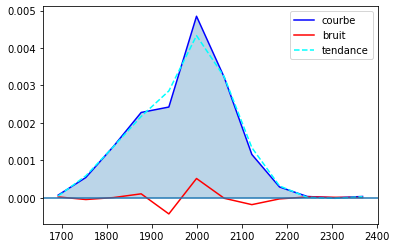

In [59]:
brten = separate(densite)
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],brten[1], color = "red", label = 'bruit')
plt.plot(brten[0],brten[2], color = "cyan", linestyle = 'dashed',label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)
plt.axhline(0)
plt.legend()
plt.show()


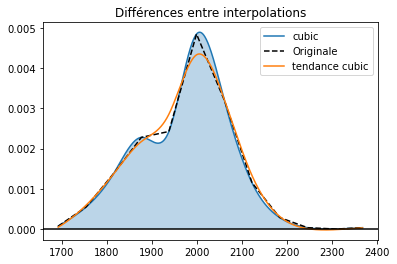

In [60]:
f=lissage(densite) 
g=lissage(densite, kind = 'linear') #l'originale
h=lissage(densite, kind = 'cubic', sep=True)

x=np.linspace(densite[0,0],densite[0,-1], int(1e5))
plt.fill_between(x,f(x), alpha = 0.3)
plt.plot(x,f(x), label = "cubic")
plt.plot(x,g(x), color = 'black', linestyle = 'dashed',label = "Originale")
plt.plot(x,h(x), label = "tendance cubic")
plt.axhline(0, color='black')
plt.legend()
plt.title('Différences entre interpolations')
plt.show()

In [61]:
#test de fonctionnement 1: densite orginale
print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))
# (0.9819998389448525, 1.329241666736536e-07) pour la 10km de Riorges
#l'interpolation linéaire fait lever un warning lors de l'intégration car elle est affine par morceaux.

#test de fonctionnement2: tendance de la densite interpolee 
print(scipy.integrate.quad(lambda x: lissage(densite, sep = True)(x),densite[0][0], densite[0][-1]))
#(0.9925168327790789, 6.901821989123772e-09) pour la 10km de Riorges

#l'interpolation cubique d'une fonction lissée donne une intégrale proche de 1 à 1e-2 pres, c'est satisfaisant.

C:\Users\tayoy\AppData\Local\Temp/ipykernel_24776/3680159937.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))


(0.9966667226739168, 4.7044030863699385e-05)
(0.9995445921342829, 8.963387077067903e-09)


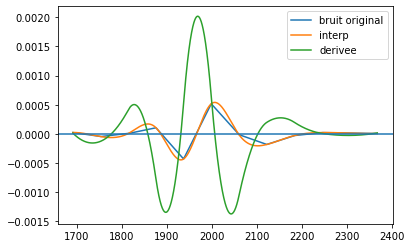

In [62]:
x= np.linspace(brten[0,0],brten[0,-1], int(1e5)) # abscisses du tracé

poly = scipy.interpolate.splrep(brten[0],brten[1]) #interpolation polynomiale par morceaux
def f0(x):
    return scipy.interpolate.splev(x, poly, der = 0) #fonction de bruit interpolee
def f1(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 1) #derivee de la fonction de bruit
def f2(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 2) #derivee seconde (pour tests de concavite)
bruit = brten[0:2,:]

g = lissage (bruit, sep=False, kind = 'linear')

h0 = f0(x)
h1 = f1(x)
plt.plot(x, g(x), label = 'bruit original')
plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.legend()
plt.axhline(0)


racines : [1693.42078056 1776.80661834 1776.8066338  1858.03063922 1931.31332393
 2006.50228319 2102.10025654 2102.10025448 2251.99948136 2251.99949934
 2251.99950105 2353.30155375]
floor : [1858.0, 1931.0, 2252.0, 1777.0, 2353.0, 2102.0, 2007.0, 1693.0]
sorted : [1693.0, 1777.0, 1858.0, 1931.0, 2007.0, 2102.0, 2252.0, 2353.0]
Comparaison : 1691.7083333333335 , 1693.0
Comparaison : 1875.9583333333335 , 1858.0
Comparaison : 1998.7916666666665 , 2007.0
Comparaison : 2244.458333333333 , 2252.0
pics : [1691.7083333333335, 1875.9583333333335, 1998.7916666666665, 2244.458333333333]


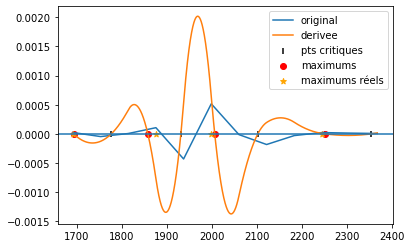

In [63]:
guess = densite[0] #on s'attend à ce que les racines de f1 soient proches des abscisses originales, puisque les maximums originaux en font partie

roots = scipy.optimize.root(f1, guess).x #trouve les points critiques de f
print(f"racines : {roots}")
#Les algorithmes de racines trouvent plusieurs fois les mêmes racines, à epsilon près. Supression des doublons:
roots = list(set(np.rint(roots))) #rint (entier le plus proche) permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
print(f"floor : {roots}")
roots=sorted(roots)
print((f"sorted : {roots}"))

tops = [] #selection des valeurs où f est concave : les maximums
for i in range (len(roots)):
    if f2(roots[i])<0:
        tops.append(roots[i])
        
realTops = [] #valeur réelle la plus proche 
for i in tops:
    ind=np.argmin(abs(densite[0]-i))
    print(f'Comparaison : {densite[0,ind]} , {i}')
    realTops=realTops+[densite[0, ind]]

    

plt.plot(brten[0], brten[1], label = 'original')
#plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.scatter(roots, [0]*len(roots), marker = '|', color = 'black', label = 'pts critiques')
plt.scatter(tops, [0]*len(tops), marker = 'o', color = 'red', label = 'maximums')
plt.scatter(realTops, [0]*len(realTops),marker = '*', color = 'orange', label = "maximums réels")
plt.axhline(0)
plt.legend()

print(f'pics : {realTops}')




In [64]:
perf=perfgoals(densite)

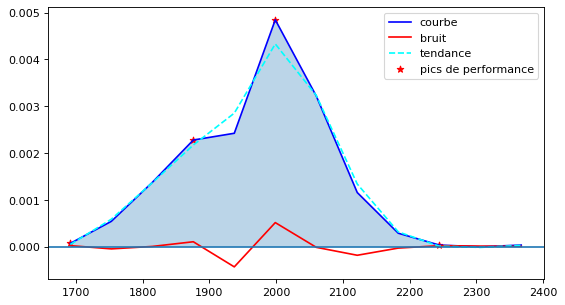

In [65]:
plt.figure(figsize=(8,4.5), dpi=80)
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],brten[1], color = "red", label = 'bruit')
plt.plot(brten[0],brten[2], color = "cyan", linestyle = 'dashed',label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)
plt.axhline(0)
plt.scatter(perf[0], perf[1], color='red', marker='*', label = "pics de performance")
plt.legend()
plt.show()